In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
import random


In [148]:
# Backpropagation algorithm
# default config for the backpropagation algo
l_rate = 0.001
max_it = 150
min_error = 0.1
# obs: changing the learning_rate and the initial weight can improve the performance
# the current config is the optimal config found for the hyperbolic tangent until this moment

# open the csv file and get the data


def get_training_data(filename):
    with open(filename) as f:
        data = pd.read_csv(f)
        data = data.values
    return data

# choose which curve will be used by the neurons of the net

# @njit(parallel=True, fastmath=True, cache=True)

@njit(cache=True)
def fx_tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)

@njit(cache=True)
def d_fx_tanh(x: np.ndarray) -> np.ndarray:
    return (1.0/np.cosh(x))**2.0

@njit(cache=True)
def fx_logistic(x: np.ndarray) -> np.ndarray:
    return 1.0/(1+np.exp(-x))

@njit(cache=True)
def d_fx_logistic(x: np.ndarray) -> np.ndarray:
    return np.exp(x)/(1+np.exp(x))**2.0

# @njit(cache=True)
def choose_curve(is_logistic: bool) -> tuple:
    if is_logistic:
        return fx_logistic, d_fx_logistic
    else:
        return fx_tanh, d_fx_tanh

# initialize the weights as small random values


@njit(cache=True)
def initialize_weights(num_classes: int, num_features: int):
    # number of inputs (class features)
    num_inputs = num_features
    # number of output neurons
    num_outputs = num_classes
    # number of hidden neurons (geometry mean of inputs and outputs)
    num_hidden = int(np.sqrt(num_inputs*num_outputs))
    # initialize the weights
    # add 0.005 in order to prevent 0
    weight_hidden = np.random.rand(num_hidden, num_inputs)/100.0 + 0.0005
    weight_output = np.random.rand(num_outputs, num_hidden) * 3.0 - 1.5
    # initialize the bias, in this case all bias = 0
    bias_hidden = np.zeros((num_hidden, num_inputs))
    bias_output = np.zeros((num_outputs, num_hidden))
    return weight_hidden, weight_output, bias_hidden, bias_output

# calculate the output from each neuron of the given layer
# each layer is described by set of weights of each neuron


def calculate_layer(weights_layer, fx, layer_inputs):
    net: np.ndarray = np.dot(layer_inputs, weights_layer.T)
    output = fx(net)
    return output

# calculate the expected output for the class


# @njit(cache=True)
def calculate_expected_values(is_logistic, class_number, num_classes):
    if is_logistic:
        expected_values = np.zeros(num_classes)
        expected_values[class_number-1] = 1
        return expected_values
    else:
        expected_values = np.full(num_classes, -1)
        expected_values[class_number-1] = 1
        return expected_values

# calculate the error for the output layer

@njit(cache=True)
def calculate_output_error(is_logistic, weights, expected, attained, inputs, fx, d_fx):
    error = (expected - attained)*d_fx(inputs)
    return error

# calculate the error for the hidden layer
# needs revision

def calculate_hidden_error(is_logistic, weights_hidden, weights_output, error_output, inputs, fx, d_fx):
    error = error_output @ weights_output
    hidden = inputs @ weights_hidden.T
    return  error*d_fx(hidden)
    # return error


# adjust the weights of a given layer according to the layer error

@njit(cache=True)
def adjust_weights(weights, learning_rate, error, layer_input):
    new_weights = np.zeros(weights.shape)
    for i in range(len(weights)):
        new_weights[i] = weights[i] + learning_rate*error[i]*layer_input
    return new_weights
    


Treinamento da rede


In [149]:
#training with an unbalanced dataset
#train a neuron net with a specificied curve and data
def train_through_data(is_logistic, data):
  #get information from the dataset
  num_classes = np.unique(data[:, -1]).size
  num_features = data.shape[1] - 1
  sample_size = data.shape[0]

  # remove the last column from the inputs list, i.e., remove the class type from inputs
  inputs = np.delete(data, len(data[0])-1, 1)
  
  #initialize the initial weights
  weight_hidden, weight_output, bias_hidden, bias_output = initialize_weights(num_classes, num_features)
  #get the function for the choosen curve
  fx, d_fx = choose_curve(is_logistic)
  
  
  #train until max_it
  for j in range(0, max_it):
    #train the net for sample in dataset
    for i in range(0, sample_size):
      #choose a random sample in order to prevent overfitting
      new_i = random.randint(0, sample_size-1)
      
      #calculate the expected value for this set of features
      expected_values = calculate_expected_values(is_logistic, data[new_i][-1], num_classes)
      
      #calculate the value for the hidden layer and the output layer
      hidden_values = calculate_layer(weight_hidden, fx, inputs[new_i])
      output_values = calculate_layer(weight_output, fx, hidden_values)
      
      #calculate the error for each layer
      error_output_layer = calculate_output_error(is_logistic, weight_output, expected_values, output_values, hidden_values, fx, d_fx)
      error_hidden_layer = calculate_hidden_error(is_logistic, weight_hidden, weight_output, error_output_layer, inputs[new_i], fx, d_fx)
      
      #adjust weights for each layer
      weight_output = adjust_weights(weight_output, l_rate, error_output_layer, hidden_values)
      weight_hidden = adjust_weights(weight_hidden, l_rate, error_hidden_layer, inputs[new_i])
    if(j % 100 == 0):
      print(j)
  #return the trained values for each layer
  return weight_hidden, weight_output



# #experimental training with a balanced dataset
# def train_through_data(is_logistic, data):
#   #get information from the dataset
#   num_classes = np.unique(data[:, -1]).size
#   num_features = data.shape[1] - 1
#   sample_size = len(data)

#   #initialize the initial weights
#   weight_hidden, weight_output, bias_hidden, bias_output = initialize_weights(num_classes, num_features)
#   #get the function for the choosen curve
#   fx, d_fx = choose_curve(is_logistic)
  
#   current_class = 1

#   #train until max_it
#   for j in range(0, max_it):
#     #train the net for sample in dataset
#     for i in range(0, sample_size):
#       #choose a random sample in order to prevent overfitting
#       sample = choose_sample(current_class, data)
      
#       #separate the class from the inputs list, i.e., remove the class type from inputs
#       sample_class = sample[-1]
#       inputs = np.delete(sample, len(sample)-1, 0)

#       #calculate the expected value for this set of features
#       expected_values = calculate_expected_values(is_logistic, sample_class, num_classes)
      
#       #calculate the value for the hidden layer and the output layer
#       hidden_values = calculate_layer(weight_hidden, fx, inputs)
#       output_values = calculate_layer(weight_output, fx, hidden_values)
      
#       #calculate the error for each layer
#       error_output_layer = calculate_output_error(is_logistic, weight_output, expected_values, output_values, hidden_values)
#       error_hidden_layer = calculate_hidden_error(is_logistic, weight_hidden, weight_output, error_output_layer, inputs)
#       #print("Expected: ")
#       #print(expected_values)
#       #print("Output: ")
#       #print(output_values)
      
#       #adjust weights for each layer
#       weight_output = adjust_weights(weight_output, l_rate, error_output_layer, hidden_values)
#       weight_hidden = adjust_weights(weight_hidden, l_rate, error_hidden_layer, inputs)

#       current_class %= num_classes
#       current_class += 1
#     if(j % 100 == 0):
#       print(j)
#   #return the trained values for each layer
#   return weight_hidden, weight_output

""""""

''

Testagem da rede


In [150]:
# the assigned class will be the index with the higher value
#@njit(cache=True)
def assign_class(output):
    return np.argmax(output) + 1

# create a confusion matrix


# def confusion_matrix():
#     return


def test_network(is_logistic, weight_hidden, weight_output, data):
    # get information from the dataset
    num_classes = np.unique(data[:, -1]).size
    confusion_matrix = np.zeros((num_classes, num_classes))

    num_features = data.shape[1] - 1
    sample_size = data.shape[0]
    # remove the last column from the inputs list, i.e., remove the class type from inputs
    inputs = np.delete(data, len(data[0])-1, 1)

    fx, d_fx = choose_curve(is_logistic)
    assigned_class = []
    true_class = []
    count_errors = 0
    for i in range(0, sample_size):
        # calculate the value for the hidden layer and the output layer
        hidden_values = calculate_layer(weight_hidden, fx, inputs[i])
        output_values = calculate_layer(weight_output, fx, hidden_values)

        # debug output
        class_index = assign_class(output_values)
        assigned_class.append(class_index)
        true_class.append(data[i][-1])
        if (true_class[i] != assigned_class[i]):
            count_errors += 1
        # print("Expected: ", true_class[i], " Attained: ", assigned_class[i])

        # debug output
        expected_values = calculate_expected_values(
            is_logistic, data[i][-1], num_classes)
        # print("Expected: ")
        # print(expected_values)
        # print("Output: ")
      # print(output_values)
        confusion_matrix[true_class[i]-1][assigned_class[i]-1] += 1

    # print('Matriz de confusão')
    plt.matshow(confusion_matrix)
    plt.colorbar()
    plt.show()

    # debug output
    print("Erros: ")
    print(count_errors)
    print("Total de amostras: ")
    print(sample_size)
    # print("Peso oculta: "
    # print(weight_hidden)
   # print("Peso saida: ")    # print(weight_output)
    return


Programa


In [151]:
def backpropagation_algo():
    is_logistic = True
    # curve = "logistic"
    data = get_training_data("treinamento.csv")
    weight_hidden, weight_output = train_through_data(is_logistic, data)

    data = get_training_data("teste.csv")
    test_network(is_logistic, weight_hidden, weight_output, data)
    return


0
100


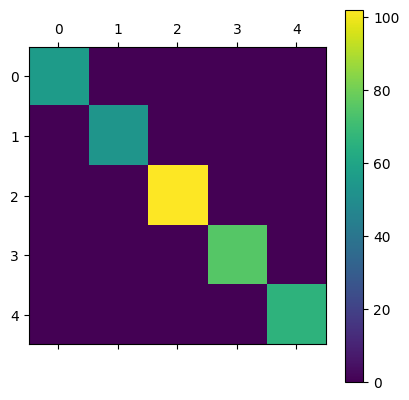

Erros: 
0
Total de amostras: 
352


In [152]:
backpropagation_algo()
